# Deep Learning - Alzheimer's prediction

This notebook aims to create a deep learning model that allows us to predict the stage of alzheimer's disease in MRI scan photos 

Bellow are the imports

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG


from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import keras

### Data preprocessing

We used the preprocessing of an existent project, as there are a lot of projects that explore this topic. Our main goal is the development of a trained model, and not cleaning or preprocessing data itself.

In [2]:
base_dir = "Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    
os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


### SMOTE

In order to balance the dataset, we are creating extra class samples, by resampling and reshaping images already existent in our dataset

In [3]:
train_data, train_labels = train_data_gen.next()

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [4]:
#train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
#train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Model Training

We are using a CNN model, as these are the best to classify images. We started with a simple model similar to the one in class, and added layers, changing paddings, in order to achieve the best results. In the very first iteration of this project, which was a direct copy paste from class, we had 32% accuracy.

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same', input_shape = (176,176,3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(Dropout(0.1))
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D(2, 2))
model.add(Dropout(0.1))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D(2, 2))
model.add(Dropout(0.1))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D(2, 2))
model.add(Dropout(0.5))
model.add(layers.Flatten())
model.add(Dense(units = 4, activation = 'softmax'))

In [6]:
model.compile(optimizer='adam', loss = "categorical_crossentropy" , metrics=['acc'])

In [7]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [8]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [9]:
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=100, callbacks=[EarlyStopping])

Epoch 1/100
255/255 [==============================] - 52s 202ms/step - loss: 1.1795 - acc: 0.4335 - val_loss: 1.0414 - val_acc: 0.5439
Epoch 2/100
255/255 [==============================] - 51s 199ms/step - loss: 0.7287 - acc: 0.6942 - val_loss: 0.9386 - val_acc: 0.5771
Epoch 3/100
255/255 [==============================] - 51s 199ms/step - loss: 0.5749 - acc: 0.7592 - val_loss: 0.7042 - val_acc: 0.6865
Epoch 4/100
255/255 [==============================] - 51s 199ms/step - loss: 0.4778 - acc: 0.8012 - val_loss: 0.7243 - val_acc: 0.6689
Epoch 5/100
255/255 [==============================] - 51s 199ms/step - loss: 0.4235 - acc: 0.8280 - val_loss: 0.6704 - val_acc: 0.7148
Epoch 6/100
255/255 [==============================] - 52s 204ms/step - loss: 0.3723 - acc: 0.8479 - val_loss: 0.6792 - val_acc: 0.7041
Epoch 7/100
255/255 [==============================] - 51s 202ms/step - loss: 0.3193 - acc: 0.8701 - val_loss: 0.5766 - val_acc: 0.7588
Epoch 8/100
255/255 [===========================

### Results

We ploted the graphs for both accuracy and loss of both training and accuracy, to see the tendency

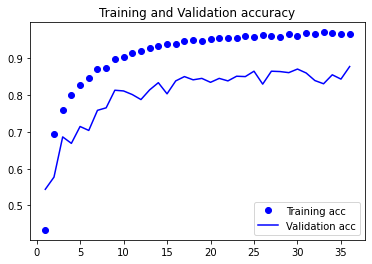

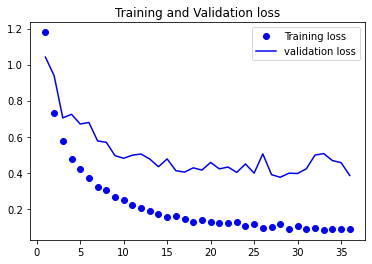

In [10]:
acc = history.history['acc'] 
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label= 'validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

### Model evaluation with test

Lastly, we will evaluate the accuracy of our model using the test data.

In [13]:
model.evaluate(test_data,test_labels)

40/40 [==============================] - 2s 39ms/step - loss: 0.3774 - acc: 0.8813


[0.3774343430995941, 0.8812500238418579]